# HSQL sums and spider plots

This notebook takes as input HQSL tables generated on Notebook 10c, produces statistical data and create plots.

## Import libraries

In [1]:
import geopandas as gpd
import pandas as pd
import numpy as np

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

import os
import sys
module_path = os.path.abspath(os.path.join('../../../'))
if module_path not in sys.path:
    sys.path.append(module_path)
    import aup

/home/edgaregurrola/Repos/observatorio-ciudades/accesibilidad-urbana/aup/data.py:24: UserWarning: The `utils.config` function is deprecated and will be removed in a future release. Instead, use the `settings` module directly to configure a global setting's value. For example, `ox.settings.log_console=True`.
  ox.config(


In [2]:
import h3
def neighbour_mean(hex_id, hex_id_name, hex_bins, col_name):
    return hex_bins.loc[hex_bins[hex_id_name].isin(h3.k_ring(hex_id,1)),col_name].mean()

## Notebook config

In [3]:
##### WARNING ##### WARNING ##### WARNING ##### WARNING ##### WARNING #####

# save output to database?
save = False
# How to save?
if_exists='append'
# save to local?
save_local = True
# use local data?
local_data = False
##### WARNING ##### WARNING ##### WARNING ##### WARNING ##### WARNING #####

In [4]:
walking_speed = 4.5
str_walking_speed = str(walking_speed).replace('.','_')
str_walking_speed

'4_5'

In [5]:
# Not running _priv educational equipments? Set pub = True. (ALSO VERIFY CHANGES IN PARAMETERS DICT)

In [5]:
# Output hexs resolution
res = 10
# Local dirs - 'alex' or 'edgar'
all_local_dirs = 'edgar'

## Load data

### Load data - processed HQSL data

### Load data - Load source matrix (summary base table)

In [7]:
if all_local_dirs == 'alex':
    grl_dir = "../../../data/external/temporal_todocker/santiago/proximidad/"
elif all_local_dirs == 'edgar':
    grl_dir = "../../../data/processed/santiago/"
else:
    print("WARNING: Fix all_local_dirs variable")

print(f"General directory: {grl_dir}")

General directory: ../../../data/processed/santiago/


In [6]:
area_analysis = 'unidadesvecinales'
code_column = 'COD_UNICO_'

In [8]:
if local_data:
    hex_gdf = gpd.read_file(grl_dir + f'santiago_hexanalysis_res{res}_{str_walking_speed}_kmh.geojson')
else:
    if area_analysis == 'hex':
        table = f'santiago_{area_analysis}analysis_{str_walking_speed}_kmh'
        schema = 'projects_research'
        query = f'SELECT * FROM {schema}.{table} WHERE res = {res}'
        hex_gdf = aup.gdf_from_query(query)
    else:
        table = f'santiago_{area_analysis}analysis_{str_walking_speed}_kmh'
        schema = 'projects_research'
        hex_gdf = aup.gdf_from_db(table, schema)

# Show
print(hex_gdf.shape)
hex_gdf.head(1)

(1070, 30)


,wellbeing_supplying,wellbeing_caring,wellbeing_living,wellbeing_enjoying,wellbeing_learning,wellbeing_working,wellbeing,sociability_supplying,sociability_caring,sociability_living,...,environmental_impact,COD_UNICO_,geometry,supplying,caring,living,enjoying,learning,working,hqsl
0,6.828092,7.539308,7.504193,10.0,6.595388,5.190426,43.657407,6.781971,4.499476,5.646487,...,41.432833,13101_1,"MULTIPOLYGON (((-70.63561 -33.43567, -70.63559...",7.165153,6.854977,6.602234,9.658674,4.314,7.595213,42.19025


### Load proximity data

In [9]:
if local_data:
    hex_gdf = gpd.read_file(grl_dir + f'santiago_hexproximity_res{res}_{str_walking_speed}_kmh.geojson')
else:
    if area_analysis == 'hex':
        table = f'santiago_hexvariableanalysis_{str_walking_speed}_kmh'
        schema = 'projects_research'
        query = f'SELECT * FROM {schema}.{table} WHERE res = {res}'
        hex_prox = aup.gdf_from_query(query)
    else:
        table = f'santiago_{area_analysis}variableanalysis_{str_walking_speed}_kmh'
        schema = 'projects_research'
        hex_prox = aup.gdf_from_db(table, schema)

# Show
print(hex_prox.shape)
hex_prox.head(1)

(1069, 168)


,COD_UNICO_,oficinas_count,hotel_count,houses_count,social_viv_count,temp_count,inter_count,noise_count,ndvi_count,geometry,...,edu_adultos_pub_scaled,edu_especial_pub_scaled,bibliotecas_scaled,centro_edu_amb_scaled,paradas_tp_ruta_scaled,paradas_tp_metro_scaled,paradas_tp_tren_scaled,oficinas_scaled,ciclovias_scaled,estaciones_bicicletas_scaled
0,13101_1,384.066322,6.327354,69.207206,0.0,-2.759405,59.677419,63.895028,8.238473,"MULTIPOLYGON (((-70.63561 -33.43567, -70.63559...",...,0.125786,0.0,5.72327,0.0,10.0,5.571279,0.0,10.0,10.0,10.0


## Parameters dictionary

In [14]:
# --- REQUIRED DATA: parameters dictionary [AS OF 2024 06 28]
# Structure: {social_functions:{themes:[source_names]}}
parameters_dict = {'supplying':{'wellbeing':['carniceria', #Accessibility to Butcher/Fish Shops
                                             'hogar', #Accessibility to Hardware/Paint Shops
                                             #Not available: Accessibility to Greengrocers
                                             'bakeries', #Accessibility to Bakeries and delis
                                             'supermercado',#Accessibility to supermarkets
                                             'banco'#Accessibility to bank
                                            ],
                                'sociability':['ferias',#Accessibility to city fairs/markets
                                               'local_mini_market',#Accessibility to local and mini markets
                                               'correos'#ADDED: MAIL SERVICE
                                              ],
                                'environmental_impact':['centro_recyc'#Accessibility to recycling center
                                                        #Not available: Accessibility to compost
                                                       ]
                               },
                   'caring':{'wellbeing':['hospital', #Accessibility to hospital
                                          'clinica',#Accessibility to public clinics
                                          'farmacia',#Accessibility to pharmacies
                                          'vacunatorio',#Accessibility to vaccination center
                                          'consult_ado',#Accessibility to optician/audiologist(###ADDED DENTIST)
                                          'salud_mental',###ADDED: MENTAL HEALTH
                                          'labs_priv',###ADDED: LABORATORIES
                                          'residencia_adumayor'###ADDED: ELDERLY PERMANENT RESIDENCIES
                                         ],
                             'sociability':['eq_deportivo',#Accessibility to sports equipments
                                            'club_deportivo'#Accessibility to sport clubs
                                           ],
                             'environmental_impact':['noise',
                                                     'temp'
                                 #Not available: Air polution
                                                    ]
                            },
                   'living':{'wellbeing':['civic_office',#Accessibility to civic offices
                                          #Not available: Number of street bentches
                                          'tax_collection',#ADDED: AFIP(TAX COLLECTOR)
                                          'social_security',#ADDED: SOCIAL SECURITY
                                          'police',#Accessibility to police(###MOVED FROM LIVING TO CARING)
                                          'bomberos'#Accessibility to fire stations
                                          #Not available: Accessibility to street lamp
                                         ],
                             'sociability':['houses',#Accessibility to permanent residencies
                                            'social_viv',#Accessibility to social housing
                                            #Not available: Accessibility to student housing
                                            'hotel'#ADDED: HOTELS
                                           ],
                             'environmental_impact':['inter',
                                                     #Not available: Corrected compactness
                                                     #Not available: Width of sidewalks
                                                    ],
                            },
                   'enjoying':{'wellbeing':['museos',#Accessibility to museums
                                            #Not available: Accessibility to theater,operas
                                            'cines',#Accessibility to cinemas
                                            'sitios_historicos',#Accessibility to historical places
                                            'ndvi'#Number of trees
                                           ],
                               'sociability':['restaurantes_bar_cafe',#Accessibility to bars/cafes + Accessibility to restaurants
                                              'librerias',#Accessibility to record and book stores, galleries, fairs
                                              #Not available: Accessibility to cultural and/or formative spaces
                                              #Not available: Accessibility to places of workship
                                              'ep_plaza_small'#Accessibility to boulevards, linear parks, small squares + Accessibility to squares
                                             ],
                               'environmental_impact':['ep_plaza_big'#Accessibility to big parks
                                                       #Not available: Accessibility to shared gardens
                                                       #Not available: Accessibility to urban playgrounds
                                                      ]
                              },
                   'learning':{'wellbeing':['edu_basica_pub',#'edu_basica_priv',#Accessibility to public elementary school
                                            'edu_media_pub',#'edu_media_priv',#Accessibility to public high school
                                            'jardin_inf_pub',#'jardin_inf_priv',#Similar to Accessibility to childcare
                                            'universidad',#Accessibility to university
                                            'edu_tecnica',#ADDED: TECHNICAL EDUCATION
                                           ],
                               'sociability':['edu_adultos_pub',#'edu_adultos_priv',#Accessibility to adult formation centers
                                              'edu_especial_pub',#'edu_especial_priv',#Accessibility to specialized educational centers
                                              #Not available: Accesibility to establishments and services for disabled adults
                                              'bibliotecas'#Accessibility to libraries(###MOVED FROM ENJOYING TO LEARNING)
                                             ],
                               'environmental_impact':['centro_edu_amb'#Accessibility to centers for learning environmental activities
                                                       #Not available: Accessibility to gardening schools
                                                      ],
                              },
                   'working':{'wellbeing':['paradas_tp_ruta',#Accessibility to bus stop
                                           'paradas_tp_metro',#Accessibility to metro
                                           'paradas_tp_tren'#Accessibility to train stop
                                          ],
                              'sociability':['oficinas'#Accessibility to office
                                             #Not available: Accessibility to incubators
                                             #Not available: AccSeveral other articles cite 60dB as a safe noise zone. essibility to coworking places
                                          ],
                              
                              'environmental_impact':['ciclovias',
                                                      'estaciones_bicicletas'#Accessibility to bike lanes
                                                      #Not available: Accessibility to shared bike stations
                                                     ]
                             }
                  }

## __Spatial area__ analysis

### Load data - Load areas of analysis

In [289]:
# SANTIAGO (AMS = Area Metropolitana de Santiago, Santiago's Metropolitan Area)
santiago_ams = gpd.read_file(grl_dir + 'zona_urbana_santiago.gpkg')
santiago_ams['name'] = 'ams'
santiago_ams = santiago_ams[['name','geometry']]
santiago_ams = santiago_ams.to_crs("EPSG:4326")

# COMUNAS
comuna_gdf = gpd.read_file(grl_dir + 'santiago_comunas.geojson')
comuna_gdf = comuna_gdf.explode()
comuna_gdf = comuna_gdf[['Comuna','geometry']]
comuna_gdf = comuna_gdf.rename(columns={'Comuna':'name'})
comuna_gdf = comuna_gdf.reset_index(drop=True)
nombre_comuna = ['Las Condes','Pedro Aguirre Cerda',
                'Quinta Normal','San Miguel',
                'Maipú','Conchalí','El Bosque',
                'Providencia']
comuna_gdf = comuna_gdf.loc[comuna_gdf.name.isin(nombre_comuna)].copy()

# ALAMEDA
if all_local_dirs == 'alex':
    alameda = gpd.read_file(grl_dir+"buffer_800m_nueva_alameda_32719.gpkg")
elif all_local_dirs == 'edgar':
    alameda = gpd.read_file(grl_dir + "buffer 800m nueva alameda.shp")
alameda['name'] = 'alameda'
alameda = alameda[['name','geometry']]
alameda = alameda.to_crs("EPSG:4326")

# ALAMEDA PONIENTE
alameda_poniente = gpd.read_file(grl_dir + 'alameda_poniente.gpkg')
alameda_poniente['name'] = 'alameda_poniente'
alameda_poniente = alameda_poniente[['name','geometry']]
alameda_poniente = alameda_poniente.to_crs("EPSG:4326")

# ALAMEDA ORIENTE
alameda_oriente = gpd.read_file(grl_dir + 'alameda_oriente.gpkg')
alameda_oriente['name'] = 'alameda_oriente'
alameda_oriente = alameda_oriente[['name','geometry']]
alameda_oriente = alameda_oriente.to_crs("EPSG:4326")

# UNIDADES VECINALES
unidades_vecinales = gpd.read_file(grl_dir + 'alameda_unidadesvecinales_clusteranalysis_v3.geojson')
unidades_vecinales['name'] = unidades_vecinales['COD_UNICO_']
unidades_vecinales = unidades_vecinales[['name','geometry']]
unidades_vecinales = unidades_vecinales.to_crs("EPSG:4326")

####################################################################################
# [Other, not used as main analysis area of interest]
# ALL UNIDADES VECINALES (Used for statistical purposes)
#all_unidades_vecinales = gpd.read_file(grl_dir + 'todas_unidades_vecinales.gpkg')
#all_unidades_vecinales['name'] = all_unidades_vecinales['COD_UNICO_']
#all_unidades_vecinales = all_unidades_vecinales[['name','geometry']]
#all_unidades_vecinales = all_unidades_vecinales.to_crs("EPSG:4326")

# ALL AOI (Region)
#santiago_aoi = aup.gdf_from_db('santiago_aoi','projects_research')
#santiago_aoi['name'] = 'aoi'
#santiago_aoi = santiago_ams[['name','geometry']]

# SANTIAGO VIV (Used at first to define santiago ams, no longer in use)
#santiago_viv = gpd.read_file(grl_dir + "viviendas_por_tipo_mnz_32719.gpkg")
#santiago_viv = santiago_viv.to_crs("EPSG:4326")

all_aoi_gdfs = [santiago_ams,comuna_gdf,alameda,alameda_poniente,alameda_oriente,unidades_vecinales]
aoi_all = pd.concat(all_aoi_gdfs,
                    ignore_index = True, axis = 0)
aoi_all

,name,geometry
0,ams,"MULTIPOLYGON (((-70.89696 -33.80372, -70.89668..."
1,San Miguel,"POLYGON ((-70.63659 -33.51873, -70.63740 -33.5..."
2,Providencia,"POLYGON ((-70.58484 -33.43126, -70.58445 -33.4..."
3,Conchalí,"POLYGON ((-70.66314 -33.39923, -70.66400 -33.3..."
4,El Bosque,"POLYGON ((-70.66324 -33.58516, -70.66340 -33.5..."
5,Las Condes,"POLYGON ((-70.53235 -33.38217, -70.53235 -33.3..."
6,Maipú,"POLYGON ((-70.76505 -33.45926, -70.76505 -33.4..."
7,Pedro Aguirre Cerda,"POLYGON ((-70.67123 -33.51069, -70.67179 -33.5..."
8,Quinta Normal,"POLYGON ((-70.70527 -33.40762, -70.70463 -33.4..."
9,alameda,"POLYGON ((-70.70775 -33.45031, -70.69297 -33.4..."


### __Select area of interest manually!__

Baseline data

In [24]:
baseline = 'alameda'
hex_gdf['area_ha'] = hex_gdf.to_crs("EPSG:32719").area / 10000
# Isolate area of interest
aoi = aoi_all.loc[aoi_all.name==baseline].copy()

# Get hexs area
def clip_data(hex_gdf, aoi):
    # Clip hexagons to spatial area of interest
    hex_clip = gpd.clip(hex_gdf, aoi)
    # Keep hexs only if at least 10% of hex inside area of interest
    hex_clip['area_clip'] = hex_clip.to_crs("EPSG:32719").area / 10000
    hex_clip['area_pct'] = hex_clip['area_clip'] / hex_clip['area_ha']
    hex_clip = hex_clip.loc[hex_clip.area_pct>=0.1].copy()
    # Create gdf for current spatial area of interest
    hex_list = list(hex_clip.hex_id.unique())
    hex_spatial = hex_gdf.loc[hex_gdf.hex_id.isin(hex_list)].copy()
    return hex_spatial

hex_baseline = clip_data(hex_gdf, aoi)
hex_baseline['name'] = baseline

Area of interest

In [437]:
# ['ams','comuna_cerro_navia','comuna_las_condes','comuna_santiago','alameda','alameda_poniente','alameda_oriente','unidades_vecinales']
area = 'Quinta Normal'

In [438]:
# For unidades vecinales, intersect data
if area == 'unidades_vecinales':
    print(f"sjoining for Unidad vecinal {area}")
    uv_list = ['13123_14','13101_49','13101_18','13101_13','13106_22','13106_12',
              '13106_06','13106_18','13106_17','13101_3']
    #ALL unidades vecinales:
    #uv_list = list(all_unidades_vecinales.name.unique())
    aoi = aoi_all.loc[aoi_all.name.isin(uv_list)].copy()
    hex_spatial = gpd.sjoin(hex_gdf, aoi)
    hex_spatial.drop(columns=['index_right'],inplace=True)

# For any other aoi, clip and keep hexs where at least 10% of the hex is inside area of interest
else:
    print(f"clipping for {area}")
    # Calculate hexs area
    hex_gdf['area_ha'] = hex_gdf.to_crs("EPSG:32719").area / 10000
    # Isolate area of interest
    aoi = aoi_all.loc[aoi_all.name==area].copy()

    # Get hexs area
    def clip_data(hex_gdf, aoi):
        # Clip hexagons to spatial area of interest
        hex_clip = gpd.clip(hex_gdf, aoi)
        # Keep hexs only if at least 10% of hex inside area of interest
        hex_clip['area_clip'] = hex_clip.to_crs("EPSG:32719").area / 10000
        hex_clip['area_pct'] = hex_clip['area_clip'] / hex_clip['area_ha']
        hex_clip = hex_clip.loc[hex_clip.area_pct>=0.1].copy()
        # Create gdf for current spatial area of interest
        hex_list = list(hex_clip.hex_id.unique())
        hex_spatial = hex_gdf.loc[hex_gdf.hex_id.isin(hex_list)].copy()
        return hex_spatial

    hex_spatial = clip_data(hex_gdf, aoi)
    hex_spatial['name'] = area

# Show
print(hex_spatial.shape)
hex_spatial.head(2)

clipping for Quinta Normal
(967, 33)


,wellbeing_supplying,wellbeing_caring,wellbeing_living,wellbeing_enjoying,wellbeing_learning,wellbeing_working,wellbeing,sociability_supplying,sociability_caring,sociability_living,...,supplying,caring,living,enjoying,learning,working,hqsl,res,area_ha,name
38,5.291667,1.250000,6.5,0.437727,2.666667,3.750000,19.896060,8.333333,0.625,0.046628,...,6.273148,1.604496,4.209987,1.104280,1.759259,3.289659,18.240829,10,1.301873,Quinta Normal
195,2.708333,2.534722,2.5,0.607225,2.583333,3.333333,14.266947,2.777778,5.000,0.365270,...,3.541667,3.249873,2.208979,1.501529,3.611111,1.752507,15.865666,10,1.302420,Quinta Normal


<AxesSubplot: >

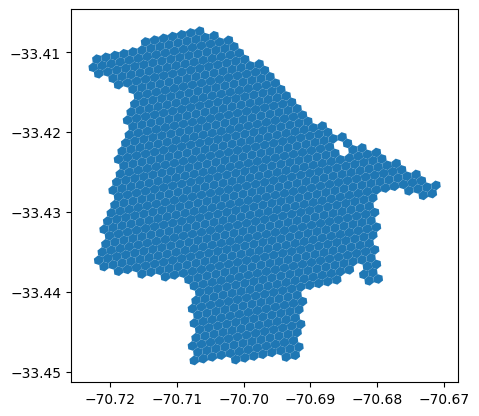

In [439]:
hex_spatial.plot()

### __For data analysis, if area = Unidades vecinales, select unidad vecinal of interest (area_name) manually!__

In [440]:
# if area='Unidades vecinales', CHOOSE UNIDAD VECINAL HERE.
# else, chosen unidad_vecinal doesn't matter.
# unidades vecinales: ['13123_14','13101_49','13101_18','13101_13','13106_22','13106_12',
#              '13106_06','13106_18','13106_17','13101_3']
unidad_vecinal = '13101_3'

if area == 'unidades_vecinales':
    area_name = unidad_vecinal
    hex_aoi = hex_spatial.loc[hex_spatial.name==unidad_vecinal].copy()
else:
    area_name = area
    hex_aoi = hex_spatial.copy()

### __Data analysis 1__ - Mean values for area of interest

In [441]:
aoi_summary = hex_aoi.copy()
# Calculate mean values for area of interest
aoi_summary = aoi_summary.drop(columns=['hex_id','geometry'])
aoi_summary = aoi_summary.groupby(['name']).mean()
aoi_summary.reset_index(inplace=True)
# Merge back to geometry
hex_new = pd.merge(aoi_all,aoi_summary,on='name',how = 'inner')
hex_new

,name,geometry,wellbeing_supplying,wellbeing_caring,wellbeing_living,wellbeing_enjoying,wellbeing_learning,wellbeing_working,wellbeing,sociability_supplying,...,environmental_impact,supplying,caring,living,enjoying,learning,working,hqsl,res,area_ha
0,Quinta Normal,"POLYGON ((-70.70527 -33.40762, -70.70463 -33.4...",2.986004,1.694522,2.865536,1.030272,2.968569,3.430138,14.975041,4.172853,...,23.634074,3.883316,2.536925,2.452522,1.825333,2.60988,2.347523,15.655499,10.0,1.302145


<AxesSubplot: >

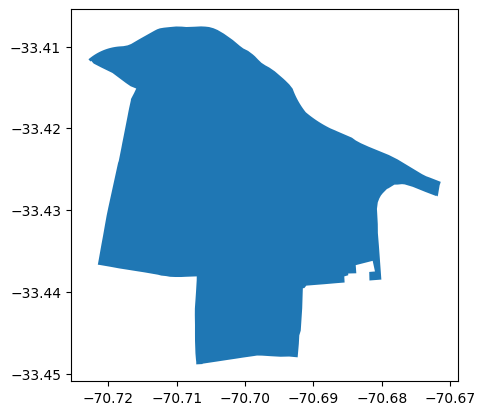

In [442]:
hex_new.plot()

### __Data analysis 3__ - Polar plots

#### Libraries used for polar plots

In [443]:
import textwrap
import matplotlib.patheffects as pe
from matplotlib.lines import Line2D
import math #importing the math functions
import matplotlib.pyplot as plt

#### Functions and definitions used for polar plots

In [444]:
def wrap_labels(ax, width, rotation, break_long_words=False):
    labels = []
    for label in ax.get_xticklabels():
        text = label.get_text()
        labels.append(textwrap.fill(text, width=width,
                      break_long_words=break_long_words))
    ax.set_xticklabels(labels, rotation=rotation, )

def make_spider(df, row, color, title, alpha, linewidth, zorder, max_graph_value, graph_div, linestyle='solid', fill=True):
    
    categories=list(df)[0:]
    N = len(categories)

    
    angles = [n / float(N) * 2 * pi for n in range(N)]
    angles += angles[:1]
     
    plt.rc('figure', figsize=(5, 5), )
 
    ax = plt.subplot(1,1,1, polar=True, )
 
    ax.set_theta_offset(pi / 2)
    ax.set_theta_direction(-1)
 
   
    plt.xticks(angles[:-1], categories, color='black', size=8,zorder=10)
    ax.tick_params(axis='x', rotation=0,pad=10, zorder=10)
    # ax.set_xlabel(labelpad=10)
    
    ax.set_rlabel_position(0)
    yticks = [i for i in range(0,max_graph_value+1, graph_div)]
    yticks_lab = [str(y) for y in yticks]
    plt.yticks(yticks, yticks_lab, color="black", size=10, zorder=10)
    plt.ylim(0,max_graph_value)
     
    
    values=df.reset_index().loc[row].values.tolist()[1:]
    values += values[:1]
    ax.plot(angles, values, color = color, linewidth=linewidth, linestyle=linestyle)
    if fill:
        ax.fill(angles, values, color = color, alpha = alpha, zorder=zorder)
         
    wrap_labels(ax, 15, 0)
  
    # title = "Radar showing performance in each subject for "+ title
    # plt.title(title, fontsize=10, x = 0.5, y = 1.1)

pi = math.pi

### __All social functions__ polar plot

#### __Save result?__ 
WARNING: OUTPUT FOLDER CHANGES according to walking speed and _pub or _all. Make sure directory exists.
* e.g. if walking_speed = 4.5 and pub=True, make sure directory '../../../output/figures/santiago/polar_plots/4_5_pub/' exists.

In [445]:
# WARNING: OUTPUT FOLDER CHANGES according to walking speed and _pub or _all. 
# Make sure directory exists
save_plots = True

In [446]:
summary_cols = ['supplying','caring','living',
               'enjoying','learning','working']
gdf_polar = hex_aoi[summary_cols].mean(axis=0)
gdf_baseline = hex_baseline[summary_cols].mean(axis=0)
gdf_polar

supplying    3.883316
caring       2.536925
living       2.452522
enjoying     1.825333
learning     2.609880
working      2.347523
dtype: float64

In [447]:
gdf_baseline

supplying    5.746714
caring       4.577360
living       4.401004
enjoying     5.902485
learning     4.369198
working      4.932325
dtype: float64

In [448]:
# Convert to df and pivot table
df = gdf_polar.copy()
df = pd.DataFrame(df).reset_index()
df.index = [0]*len(df)
df = df.rename(columns={'index':'social_fn',0:'value'})
df = df.pivot(columns='social_fn', values='value')
# baseline data
df_baseline = gdf_baseline.copy()
df_baseline = pd.DataFrame(df_baseline).reset_index()
df_baseline.index = [0]*len(df_baseline)
df_baseline = df_baseline.rename(columns={'index':'social_fn',0:'value'})
df_baseline = df_baseline.pivot(columns='social_fn', values='value')
df

social_fn,caring,enjoying,learning,living,supplying,working
0,2.536925,1.825333,2.60988,2.452522,3.883316,2.347523


In [449]:
df_baseline

social_fn,caring,enjoying,learning,living,supplying,working
0,4.57736,5.902485,4.369198,4.401004,5.746714,4.932325


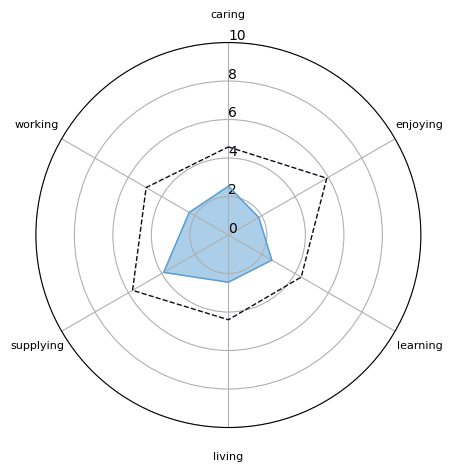

In [450]:
plt.figure()

# Convert 'sf_scaledcount names' to 'sf' for plot
df = df.rename(columns={'caring':'Caring',
                       'working':'Working',
                       'enjoying':'Enjoying',
                       'supplying':'Supplying',
                        'living':'Living',
                        'learning':'Learning'})

df_bas090e19eline = df_baseline.rename(columns={'caring':'Caring',
                       'working':'Working',
                       'enjoying':'Enjoying',
                       'supplying':'Supplying',
                        'living':'Living',
                        'learning':'Learning'})
# Graph
color = '#599fd5'
make_spider(row=0, df = df, title = area_name, 
            color = color, alpha=0.5, linewidth=1, zorder=-1,
            max_graph_value = 10, graph_div = 2)


color = '#090e19'
make_spider(row=0, df = df_baseline, title = 'Alameda', 
            color = color, alpha=0.5, linewidth=1, zorder=-1,
            max_graph_value = 10, graph_div = 2, linestyle='dashed', fill=False)

# Save
plt.savefig(f'../../../output/figures/santiago/polar_plots/{str_walking_speed}/SocialFunctions_{area_name}_all.svg')

### Indicators bar-charts

<AxesSubplot: >

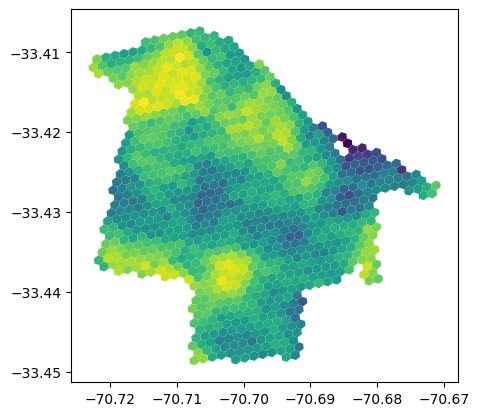

In [451]:
hex_aoi.plot('environmental_impact')

In [452]:
summary_cols = ['wellbeing','sociability','environmental_impact']
gdf_polar = hex_aoi[summary_cols].mean(axis=0)
# Convert to df and pivot table
df = gdf_polar.copy()
df = pd.DataFrame(df).reset_index()
df.index = [0]*len(df)
df = df.rename(columns={'index':'indicator',0:'value'})
df = df.pivot(columns='indicator', values='value')

In [453]:
gdf_polar

wellbeing               14.975041
sociability             13.915808
environmental_impact    23.634074
dtype: float64

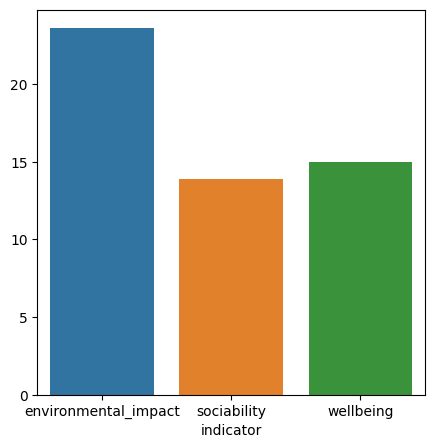

In [454]:
plt.figure()
sns.barplot(df)
plt.savefig(f'../../../output/figures/santiago/polar_plots/{str_walking_speed}/Indicators_{area_name}_all.svg')

### Spatial area polar graph - Shows each social function's sources

In [455]:
save_plots = True

In [456]:
color = '#599fd5'

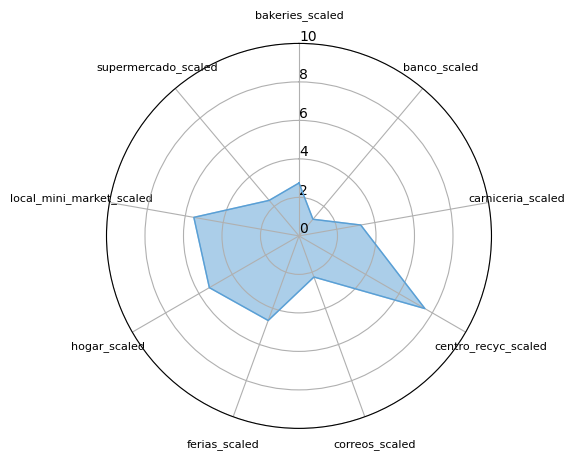

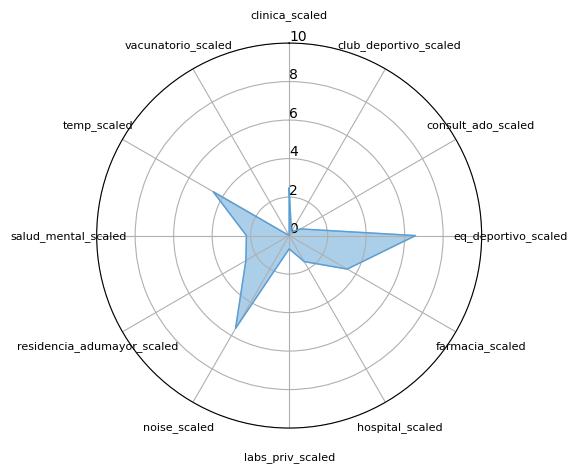

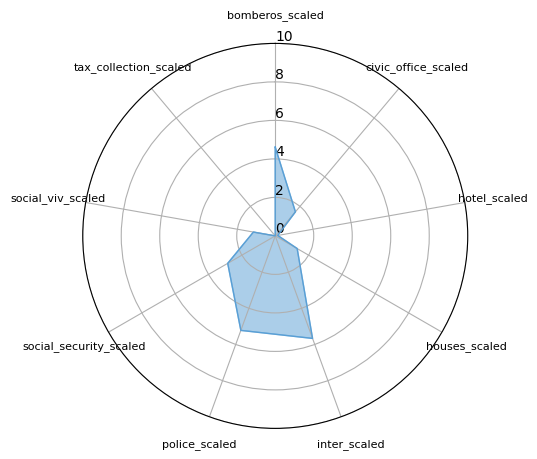

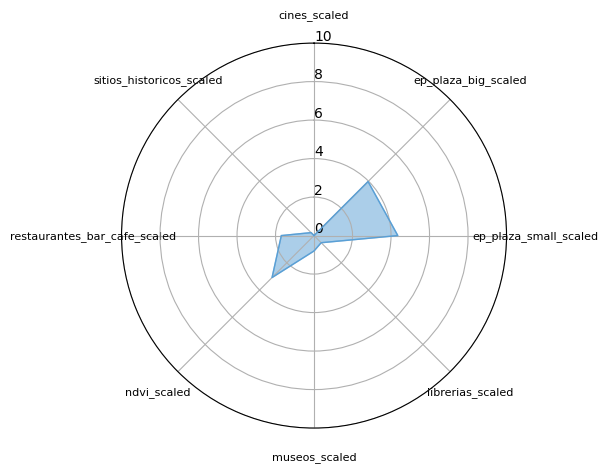

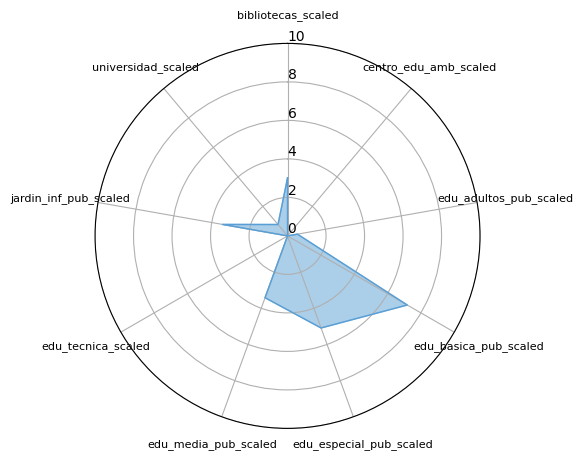

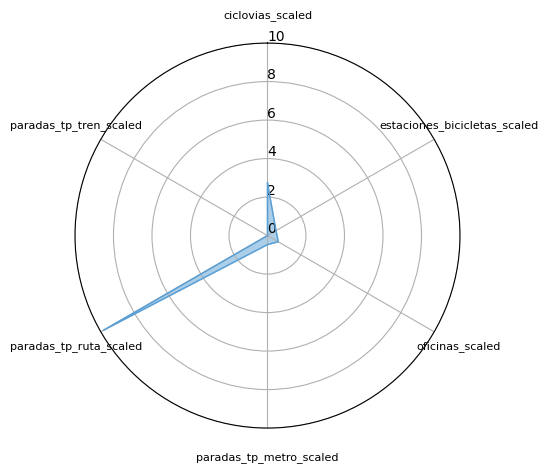

In [457]:
for social_fn_graph in parameters_dict.keys():
    plt.figure()

    metric_list = []

    # Convert social function 'sf_count_15min' name to 'sf_scaledcount' name
    for val in parameters_dict[social_fn_graph].values():
        for v in val:
            metric_list.append(v+'_scaled')

    # Get mean values for values of interest
    gdf_polar = hex_prox.loc[hex_prox.hex_id.isin(hex_aoi.hex_id),metric_list].mean(axis=0)

    # Convert to df and pivot table
    df = gdf_polar.copy()
    df = pd.DataFrame(df).reset_index()
    df.index = [0]*len(df)
    df = df.rename(columns={'index':social_fn_graph, 0:'value'})
    df = df.pivot(columns=social_fn_graph, values='value')

    # Convert 'metric_scaledcount names' to 'metric' for plot
    for val in parameters_dict[social_fn_graph].values():
        for v in val:
            df = df.rename(columns={v+'_scaledcount':v})

    # Graph
    make_spider(row=0, df = df, title = area, 
                color = color, alpha=0.5, linewidth=1, zorder=-1,
                max_graph_value = 10, graph_div = 2)

    # Save
    if save_plots:
        plt.savefig(f'../../../output/figures/santiago/polar_plots/{str_walking_speed}/Social_Fn/SocialFunctions_{area_name}_{social_fn_graph}.svg')